# Setup
--> "Runtime" --> "Change runtime type" --> "GPU" hardware accelerator

## Installs

In [1]:
! pip install -qU tensorflow_datasets

     |████████████████████████████████| 4.0 MB 5.0 MB/s 


## Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.utils import np_utils

import tensorflow_datasets as tfds

# Eurostat Data

In [3]:
%%html
<iframe src="https://ec.europa.eu/eurostat/databrowser/view/lan_lcv_ovw/default/table?lang=en" width="1000" height="600"></iframe>

# EuroSAT Dataset
https://www.tensorflow.org/datasets/catalog/eurosat

## Download Data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling eurosat-train.tfrecord...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to ./eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


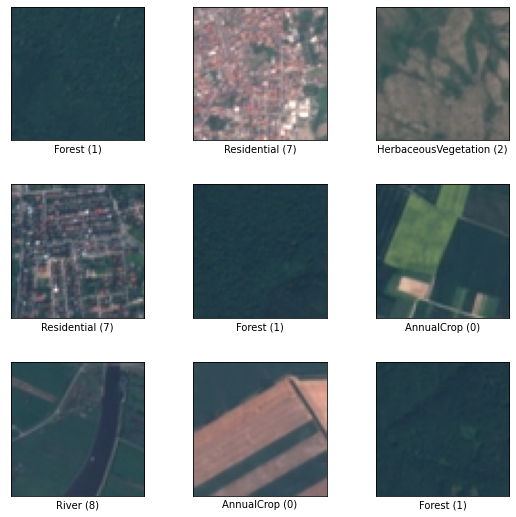

In [4]:
ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir='.')

tfds.show_examples(ds, ds_info);

In [5]:
print(ds_info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='./eurosat/rgb/2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_sh

## Load into Pandas

In [6]:
%%time
df = tfds.as_dataframe(ds, ds_info)
print(df.shape)

(27000, 3)
CPU times: user 19 s, sys: 3.48 s, total: 22.5 s
Wall time: 9.81 s


In [7]:
df.sample(5)

,filename,image,label
19420,b'AnnualCrop_2842.jpg',"[[[82, 113, 107], [83, 114, 109], [85, 114, 11...",0
541,b'SeaLake_2715.jpg',"[[[31, 56, 86], [31, 56, 86], [34, 54, 87], [3...",9
14507,b'AnnualCrop_1926.jpg',"[[[180, 147, 140], [180, 147, 140], [180, 145,...",0
8409,b'Industrial_1884.jpg',"[[[86, 87, 105], [88, 90, 105], [108, 107, 121...",4
15919,b'HerbaceousVegetation_2153.jpg',"[[[51, 64, 72], [50, 63, 71], [47, 61, 72], [4...",2


## Target Distribution

In [8]:
df.groupby('label')['label'].value_counts()

label  label
0      0        3000
1      1        3000
2      2        3000
3      3        2500
4      4        2500
5      5        2000
6      6        2500
7      7        3000
8      8        2500
9      9        3000
Name: label, dtype: int64

## Image Dimensions

In [9]:
df['image'][0].shape

(64, 64, 3)

## Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values), 
                                                    test_size=0.333333, 
                                                    shuffle=True,
                                                    random_state=10)
print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 64, 64, 3) (18000,)
Test:  (9000, 64, 64, 3) (9000,)


## OneHot Encode the Label

In [11]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [12]:
print(y_train.shape, y_test.shape)
print(y_train[:4])

(18000, 10) (9000, 10)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


# Transfer Learning

- A pretrained base for feature extraction
- A custom head for classification

## Big Data

In [13]:
%%html
<iframe src="https://image-net.org/about.php" width="1000" height="600"></iframe>

<img src="https://machinelearningmastery.com/wp-content/uploads/2017/08/Sample-of-Images-from-the-ImageNet-Dataset-used-in-the-ILSVRC-Challenge.png"/>

## Oxford's [VGG](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

### Pretrained Base


In [14]:
from keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

### Headless & Customized VGG

In [15]:
model_base = VGG16(include_top=False,
                   pooling='avg',
                   input_tensor=layers.Input(shape=(64, 64, 3)))
model_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

### New Head

In [16]:
def vgg():
  model_base.trainable = False

  model = keras.Sequential([
      model_base,
      layers.Flatten(),
      layers.Dense(128, activation='relu', name='dense_1'),
      layers.Dropout(0.5, name='drop_1'),
      layers.Dense(64, activation='relu', name='dense_2'),
      layers.Dropout(0.5, name='drop_2'),
      layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [17]:
model = vgg()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
drop_1 (Dropout)             (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
drop_2 (Dropout)             (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 10)                6

### Prepare Data
Pixel scaling is performed in a way that was performed to images in the training dataset when the model was developed.

In [18]:
from keras.applications.vgg16 import preprocess_input

X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values), 
                                                    test_size=0.333333, 
                                                    shuffle=True,
                                                    random_state=10)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

### Train Model

In [19]:
%%time
model = vgg()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 24s 107ms/step - loss: 3.2609 - accuracy: 0.3167 - val_loss: 1.0796 - val_accuracy: 0.7107
Epoch 2/100
60/60 [==============================] - 3s 50ms/step - loss: 1.4439 - accuracy: 0.5277 - val_loss: 0.7451 - val_accuracy: 0.8089
Epoch 3/100
60/60 [==============================] - 3s 50ms/step - loss: 1.1104 - accuracy: 0.6508 - val_loss: 0.5959 - val_accuracy: 0.8541
Epoch 4/100
60/60 [==============================] - 3s 50ms/step - loss: 0.9251 - accuracy: 0.7176 - val_loss: 0.5206 - val_accuracy: 0.8574
Epoch 5/100
60/60 [==============================] - 3s 50ms/step - loss: 0.7854 - accuracy: 0.7595 - val_loss: 0.4674 - val_accuracy: 0.8756
Epoch 6/100
60/60 [==============================] - 3s 50ms/step - loss: 0.6791 - accuracy: 0.7982 - val_loss: 0.4282 - val_accuracy: 0.8863
Epoch 7/100
60/60 [==============================] - 3s 50ms/step - loss: 0.6283 - accuracy: 0.8146 - val_loss: 0.4075 - val_accuracy: 0.8893
Epoc

### Evaluate Model Performance

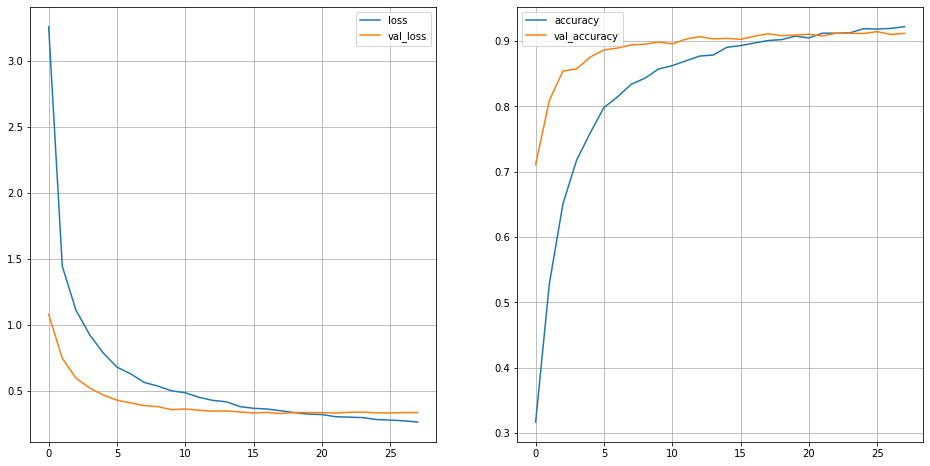

VGG Error: 9.21%


In [20]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("VGG Error: %.2f%%" % (100-scores[1]*100))

## Google's [Inception](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)

<img src="https://miro.medium.com/max/1024/1*cwR_ezx0jliDvVUV6yno5g.jpeg"/>

### Pretrained Base

In [21]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3()
model.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

### Headless & Customized Inception

In [22]:
model_base = InceptionV3(include_top=False,
                         pooling='avg',
                         input_tensor=layers.Input(shape=(128, 128, 3)))
model_base.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_94[0][0]     
______________________

### New Head

In [23]:
def inception():
  model_base.trainable = False

  model = keras.Sequential([
      model_base,
      layers.Flatten(),
      layers.Dense(128, activation='relu', name='dense_1'),
      layers.Dropout(0.5, name='drop_1'),
      layers.Dense(64, activation='relu', name='dense_2'),
      layers.Dropout(0.5, name='drop_2'),
      layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [24]:
model = inception()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
drop_1 (Dropout)             (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
drop_2 (Dropout)             (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 10)               

### Prepare Data
- Upscale the images for the inception architecture "to make sense".
- Pixel scaling is performed in a way that was performed to images in the training dataset when the model was developed.

In [25]:
from keras.applications.inception_v3 import preprocess_input

X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values), 
                                                    test_size=0.333333, 
                                                    shuffle=True,
                                                    random_state=10)

X_train = preprocess_input(X_train).repeat(2, axis=1).repeat(2, axis=2)
X_test = preprocess_input(X_test).repeat(2, axis=1).repeat(2, axis=2)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 128, 128, 3) (18000, 10)
Test:  (9000, 128, 128, 3) (9000, 10)


### Train Model

In [26]:
%%time
model = inception()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 15s 159ms/step - loss: 1.9445 - accuracy: 0.3278 - val_loss: 1.1451 - val_accuracy: 0.7167
Epoch 2/100
60/60 [==============================] - 7s 112ms/step - loss: 1.2953 - accuracy: 0.5754 - val_loss: 0.7906 - val_accuracy: 0.7870
Epoch 3/100
60/60 [==============================] - 7s 112ms/step - loss: 1.0695 - accuracy: 0.6535 - val_loss: 0.6873 - val_accuracy: 0.8230
Epoch 4/100
60/60 [==============================] - 7s 113ms/step - loss: 0.9575 - accuracy: 0.6964 - val_loss: 0.6047 - val_accuracy: 0.8363
Epoch 5/100
60/60 [==============================] - 7s 113ms/step - loss: 0.8800 - accuracy: 0.7192 - val_loss: 0.5788 - val_accuracy: 0.8407
Epoch 6/100
60/60 [==============================] - 7s 113ms/step - loss: 0.8145 - accuracy: 0.7457 - val_loss: 0.5536 - val_accuracy: 0.8526
Epoch 7/100
60/60 [==============================] - 7s 112ms/step - loss: 0.7821 - accuracy: 0.7565 - val_loss: 0.5330 - val_accuracy: 0.851

### Evaluate Model Performance

In [27]:
del X_train

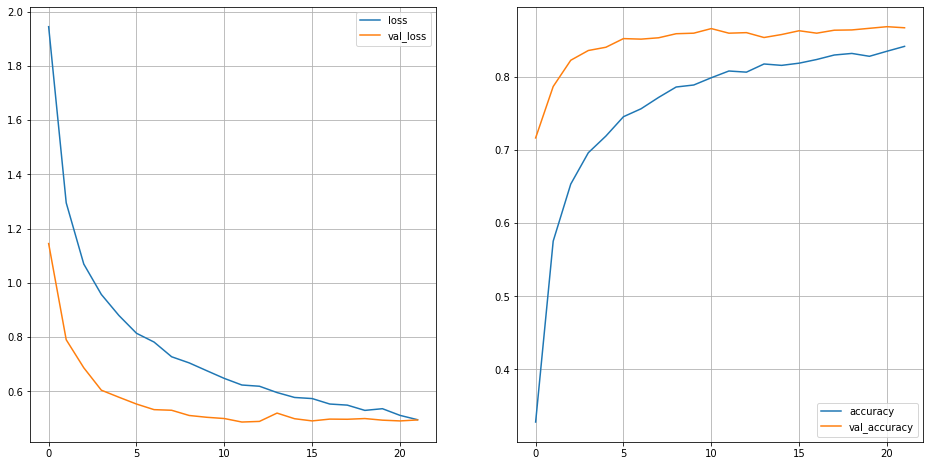

Inception Error: 13.74%


In [28]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("Inception Error: %.2f%%" % (100-scores[1]*100))

## Microsoft's [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network)

### Pretrained Base

In [29]:
from keras.applications.resnet import ResNet50
model = ResNet50()
model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

### Headless & Customized ResNet

In [30]:
model_base = ResNet50(include_top=False,
                      pooling='avg',
                      input_tensor=layers.Input(shape=(128, 128, 3)))
model_base.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
__________________________

### New Head

In [31]:
def resnet():
  model_base.trainable = False

  model = keras.Sequential([
      model_base,
      layers.Flatten(),
      layers.Dense(128, activation='relu', name='dense_1'),
      layers.Dropout(0.5, name='drop_1'),
      layers.Dense(64, activation='relu', name='dense_2'),
      layers.Dropout(0.5, name='drop_2'),
      layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### Prepare Data

In [32]:
from keras.applications.resnet import preprocess_input

X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values), 
                                                    test_size=0.333333, 
                                                    shuffle=True,
                                                    random_state=10)

X_train = preprocess_input(X_train).repeat(2, axis=1).repeat(2, axis=2)
X_test = preprocess_input(X_test).repeat(2, axis=1).repeat(2, axis=2)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 128, 128, 3) (18000, 10)
Test:  (9000, 128, 128, 3) (9000, 10)


### Train Model

In [33]:
%%time
model = resnet()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 16s 191ms/step - loss: 1.2905 - accuracy: 0.5761 - val_loss: 0.3389 - val_accuracy: 0.9067
Epoch 2/100
60/60 [==============================] - 9s 158ms/step - loss: 0.5448 - accuracy: 0.8366 - val_loss: 0.2167 - val_accuracy: 0.9367
Epoch 3/100
60/60 [==============================] - 9s 158ms/step - loss: 0.4078 - accuracy: 0.8812 - val_loss: 0.1864 - val_accuracy: 0.9422
Epoch 4/100
60/60 [==============================] - 9s 158ms/step - loss: 0.3382 - accuracy: 0.9037 - val_loss: 0.1722 - val_accuracy: 0.9504
Epoch 5/100
60/60 [==============================] - 9s 159ms/step - loss: 0.2805 - accuracy: 0.9173 - val_loss: 0.1603 - val_accuracy: 0.9533
Epoch 6/100
60/60 [==============================] - 9s 158ms/step - loss: 0.2495 - accuracy: 0.9307 - val_loss: 0.1599 - val_accuracy: 0.9530
Epoch 7/100
60/60 [==============================] - 9s 158ms/step - loss: 0.2291 - accuracy: 0.9340 - val_loss: 0.1528 - val_accuracy: 0.958

### Evaluate Model Performance

In [34]:
del X_train

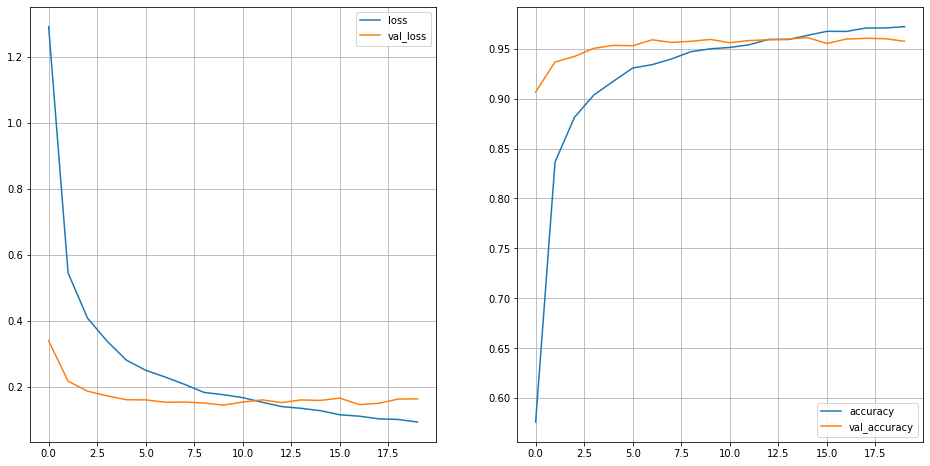

Inception Error: 4.98%


In [35]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("Inception Error: %.2f%%" % (100-scores[1]*100))

# Data Augmentation

- Fake data can be very useful
- Keras has some [tricks](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_flip/) up its sleeves

## Prepare Data

In [37]:
from keras.applications.resnet import preprocess_input

X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values), 
                                                    test_size=0.333333, 
                                                    shuffle=True,
                                                    random_state=10)

X_train = preprocess_input(X_train).repeat(2, axis=1).repeat(2, axis=2)
X_test = preprocess_input(X_test).repeat(2, axis=1).repeat(2, axis=2)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 128, 128, 3) (18000, 10)
Test:  (9000, 128, 128, 3) (9000, 10)


In [38]:
from tensorflow.keras.layers.experimental import preprocessing

In [39]:
def augmented():
  model_base.trainable = False

  model = keras.Sequential([
    # Data Aug
    preprocessing.RandomContrast(factor=0.2),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.2),

    # ResNet base
    model_base,

    # Custom head
    layers.Flatten(),
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='drop_1'),
    layers.Dense(64, activation='relu', name='dense_2'),
    layers.Dropout(0.5, name='drop_2'),
    layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

## Train Model

In [40]:
%%time
model = augmented()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=20,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 17s 208ms/step - loss: 1.4601 - accuracy: 0.5227 - val_loss: 0.4079 - val_accuracy: 0.8885
Epoch 2/100
60/60 [==============================] - 11s 179ms/step - loss: 0.6826 - accuracy: 0.7965 - val_loss: 0.2982 - val_accuracy: 0.9174
Epoch 3/100
60/60 [==============================] - 11s 180ms/step - loss: 0.5289 - accuracy: 0.8439 - val_loss: 0.2721 - val_accuracy: 0.9215
Epoch 4/100
60/60 [==============================] - 11s 180ms/step - loss: 0.4443 - accuracy: 0.8728 - val_loss: 0.2299 - val_accuracy: 0.9378
Epoch 5/100
60/60 [==============================] - 11s 180ms/step - loss: 0.4106 - accuracy: 0.8824 - val_loss: 0.2011 - val_accuracy: 0.9407
Epoch 6/100
60/60 [==============================] - 11s 181ms/step - loss: 0.3711 - accuracy: 0.8927 - val_loss: 0.2075 - val_accuracy: 0.9385
Epoch 7/100
60/60 [==============================] - 11s 180ms/step - loss: 0.3366 - accuracy: 0.9043 - val_loss: 0.1887 - val_accuracy:

## Evaluate Model Performance

In [41]:
del X_train

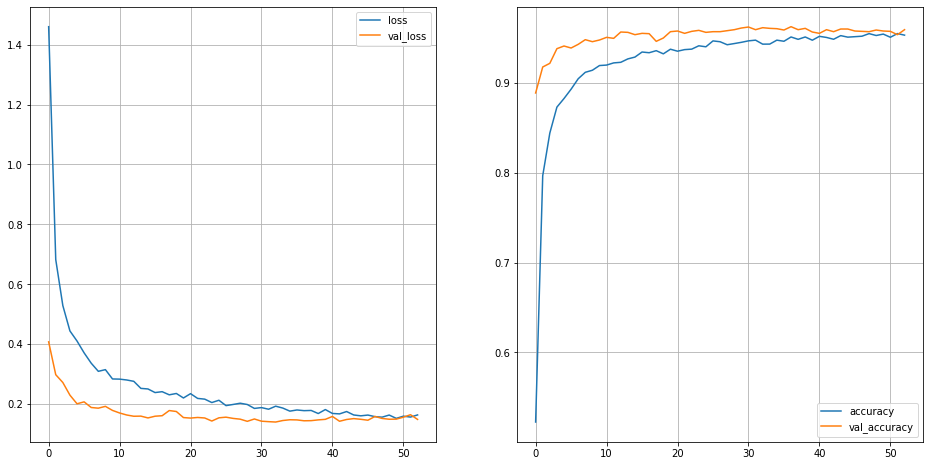

Inception Error: 4.89%


In [42]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("Inception Error: %.2f%%" % (100-scores[1]*100))